In [5]:
# Import function to calclulate geometry matrix of system
from Impedance_matrix import Matrix, Mnm, L_orthogonal, L_parallel
from Ring_Class import Ring

from Parameters_anisotropic import Rectangle_packing as RP_anizo
from Parameters_anisotropic import Hexagonal_packing as HP_anizo
from Parameters_anisotropic import Params as Params_anizo

from Verifying_MRI.Parameters_MRI import Rectangle_packing as RP_izo
from Verifying_MRI.Parameters_MRI import Rectangle_packing as HP_izo
from Verifying_MRI.Parameters_MRI import Params as Params_izo

In [148]:
# Time estimation for anisotropic structure
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.optimize import curve_fit
from scipy.fft import fftn, ifftn
from functools import reduce
from random import random
from time import time as time
from numpy import sqrt
import json

def multiply(Matrix, Vec):
    res = np.zeros(len(Matrix), dtype = complex)
    for i in range(len(res)):
        res[i] = sum([Matrix[i][j] * Vec[j] for j in range(len(Vec))])
    return res

Matrix_time = np.array([], dtype=np.float64)
Solving_time = np.array([], dtype=np.float64)

FFT_time = np.array([], dtype=np.float64)
FFT_time_I = np.array([], dtype=np.float64)
FFT_time_ZI = np.array([], dtype=np.float64)
FFT_time_V = np.array([], dtype=np.float64)

Delta_Matrix = np.array([], dtype=np.float64)
Delta_Solving = np.array([], dtype=np.float64)

Delta_FFT = np.array([], dtype=np.float64)
Delta_FFT_I = np.array([], dtype=np.float64)
Delta_FFT_V = np.array([], dtype=np.float64)
Delta_FFT_ZI = np.array([], dtype=np.float64)

Numbers = np.array([], dtype=np.float64)

#DATA = {}
Mu = []

Dimensions = ('z', 'y', 'x')
Orientation = 'z'

for n in range(1, 15):
    print(n)
    N = {}

    N['x'], N['y'], N['z'] = n, n, 3 * n
    nz = N[f"z"] + N[f"z"] - 1
    ny = N[f"y"] + N[f"y"] - 1
    nx = N[f"x"] + N[f"x"] - 1
    dim_old = N['z'] * N['z'] * N['y'] * N['y'] * N['x'] * N['x']
    dim_new = (N['z'], N['z'], N['y'], N['y'], N['x'], N['x'])

    b = a/3
    Rings = Rectangle_packing(N["x"], N["y"], N['z'], Radius, a, b, c, w)
    Number = len(Rings)

    Z = Matrix(Rings, Rings, DATA) * a1/a * mu_0 * 1j * omega_0
    Z_6d = Z.reshape(dim_old).reshape(dim_new)
    Z_circvecs = np.zeros((nz, ny, nx), dtype = complex)
    i_vecs = np.zeros((nz, ny, nx), dtype=complex)
    ZI_fft = np.zeros(Number, dtype=complex)

    print('Matrix:Done')

    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= N['x'])
                x_col_id = x * (x < N['x'])

                y_str_id = (ny - y) * (y >= N['y'])
                y_col_id = y * (y < N['y'])

                z_str_id = (nz - z) * (z >= N['z'])
                z_col_id = z * (z < N['z'])

                Z_circvecs[z][y][x] = Z_6d[z_str_id][z_col_id][y_str_id][y_col_id][x_str_id][x_col_id]

    print('Circulant:done')
          
    fft_time, fft_time2, fft_time_i, fft_time_i2 = 0,0,0,0
    fft_time_zi, fft_time_zi2, fft_time_v, fft_time_v2 = 0,0,0,0

    I = np.linspace(Number // 10, Number * 2, Number)
    repeat = 10
    for j in range(repeat):

        Start = np.float64(time())

        Start_i = np.float64(time())

        Z_0 = Z_0
    
        i_vecs[:N['z'], :N['y'], :N['x']] = I.reshape((N['z'], N['y'], N['x']))
        

        End_i = np.float64(time())

        Start_zi = np.float64(time())

        ZI_circ = fftn(fftn(Z_circvecs) * ifftn(i_vecs))

        End_zi = np.float64(time())

        Start_v = np.float64(time())

        ZI_fft = ZI_circ[:N['z'], :N['y'], :N['x']].reshape(Number)
        

        End_v = np.float64(time())

        End = np.float64(time())

        fft_time += (End - Start) /repeat
        fft_time2 += (End - Start) ** 2 /repeat

        fft_time_i += (End_i - Start_i) /repeat
        fft_time_i2 += (End_i - Start_i) ** 2 /10

        fft_time_zi += (End_zi - Start_zi) /repeat
        fft_time_zi2 += (End_zi - Start_zi) ** 2 /repeat

        fft_time_v += (End_v - Start_v) /repeat
        fft_time_v2 += (End_v - Start_v) ** 2 /repeat

    print('Fourier trasnform: Done')

    # Multiplying by straight way
    matrix_time = 0
    matrix_time2 = 0
    repeat = 10
    for i in range(repeat):
        Start = np.float64(time())

        ZI = Z.dot(I)

        End = np.float64(time())

        matrix_time += (End - Start) / repeat
        matrix_time2 += (End - Start) ** 2 / repeat


    Matrix_time = np.append(Matrix_time, matrix_time)
    Delta_Matrix = np.append(Delta_Matrix, sqrt(matrix_time2 - matrix_time ** 2))
    FFT_time = np.append(FFT_time, fft_time)
    Delta_FFT = np.append(Delta_FFT, sqrt(fft_time2 - fft_time ** 2))
    FFT_time_I = np.append(FFT_time_I, fft_time_i)
    Delta_FFT_I = np.append(Delta_FFT_I, sqrt(fft_time_i2 - fft_time_i ** 2))
    FFT_time_ZI = np.append(FFT_time_ZI, fft_time_zi)
    Delta_FFT_ZI = np.append(Delta_FFT_ZI, sqrt(fft_time_zi2 - fft_time_zi ** 2))
    FFT_time_V = np.append(FFT_time_V, fft_time_v)
    Delta_FFT_V = np.append(Delta_FFT_V, sqrt(fft_time_v2 - fft_time_v ** 2))
    Numbers = np.append(Numbers, Number)
            
    Omega = 10 ** 10
    middle_ring_id = N['z'] // 2 * N['y'] * N['x'] + N['y']//2 * N['x'] + N['x']// 2
    # Calculate sum only with neighbours



Time_estimation = {
    "Numbers": list(Numbers),
    "Matrix Time": list(Matrix_time),
    "FFT Time": list(FFT_time),
    "FFT Time I": list(FFT_time_I),
    "FFT Time V": list(FFT_time_V),
    "FFT Time ZI": list(FFT_time_ZI),
    "Delta Matrix": list(Delta_Matrix),
    "Delta FFT": list(Delta_FFT),
    "Delta FFT I": list(Delta_FFT_I),
    "Delta FFT V": list(Delta_FFT_V),
    "Delta FFT ZI": list(Delta_FFT_ZI),
}

with open("DATA/Time_estimation2.json", "w") as res:
    res.write(json.dumps(Time_estimation))

1
Matrix:Done
Circulant:done
Fourier trasnform: Done
2
Matrix:Done
Circulant:done
Fourier trasnform: Done
3
Matrix:Done
Circulant:done
Fourier trasnform: Done
4
Matrix:Done
Circulant:done
Fourier trasnform: Done
5
Matrix:Done
Circulant:done
Fourier trasnform: Done
6
Matrix:Done
Circulant:done
Fourier trasnform: Done
7
Matrix:Done
Circulant:done
Fourier trasnform: Done
8
Matrix:Done
Circulant:done
Fourier trasnform: Done
9
Matrix:Done
Circulant:done
Fourier trasnform: Done
10
Matrix:Done
Circulant:done
Fourier trasnform: Done
11
Matrix:Done
Circulant:done
Fourier trasnform: Done
12
Matrix:Done
Circulant:done
Fourier trasnform: Done
13
Matrix:Done
Circulant:done
Fourier trasnform: Done
14
Matrix:Done
Circulant:done
Fourier trasnform: Done


In [161]:
# Time estimation for anisotropic structure (without full matrix)
import numpy as np
import pyfftw
from timeit import default_timer as timer
from numpy import sqrt
import json


def Circvec(rings_3d, data):
    nz, ny, nx = rings_3d.shape
    nz, ny, nx = 2*nz-1, 2*ny-1, 2*nx-1
    Z_circvecs = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    for z in range(nz):
        for y in range(ny):
            for x in range(nx):
                x_str_id = (nx - x) * (x >= N['x'])
                x_col_id = x * (x < N['x'])

                y_str_id = (ny - y) * (y >= N['y'])
                y_col_id = y * (y < N['y'])

                z_str_id = (nz - z) * (z >= N['z'])
                z_col_id = z * (z < N['z'])
                
                Z_circvecs[z][y][x] = Mnm(rings_3d[z_str_id][y_str_id][x_str_id], rings_3d[z_col_id][y_col_id][x_col_id], data)
    return Z_circvecs
 


# Arrays which contain time dependecy and parameters of modeling
FFT_time_I = []
FFT_time_V = []
FFT_time_ZI = []
FFT_time = []
Numbers = []

# Data list to collect mutual inductance and avoid 
# multiple calculating
DATA = {}
# List for effective magnetic permeability and polarization
Mu = []
Polarisation = []

# Dimensions contains possibla coordinates of rings, Orientations - possible direction of normal to the plain of rings
# Orientation influence on number of Tyoplitz blocks of matrix, dimension determines dimension for symmetry in each block
Dimensions = ('z', 'y', 'x')
Orientation = 'z'

# Analysize structures with same xy-dimension and thrice reduced distance between rings planes
for n in ([i for i in range(2, 20)] + [60]):
    print(n)
    N = {}

    N['x'], N['y'], N['z'] = n, n, 3 * n
    # Calculate dimension of circulante matrix
    nz = N[f"z"] + N[f"z"] - 1
    ny = N[f"y"] + N[f"y"] - 1
    nx = N[f"x"] + N[f"x"] - 1
    
    #Parameters to reshape matrix (correct order in tuple is neccesary)
    dim_old = N['z'] * N['z'] * N['y'] * N['y'] * N['x'] * N['x']
    dim_new = (N['z'], N['z'], N['y'], N['y'], N['x'], N['x'])

    # b means distance between z-axes
    b = a/3
    # Made list of rings with correct position and mash
    Rings = Rectangle_packing(N["x"], N["y"], N['z'], Radius, a, b, c, w)
    Rings_3d = Rings.reshape((N['z'], N['y'], N['x']))
    # Total number of rings
    Number = len(Rings)
    
    # Premade lists for results of calculating
    # Calculate only circulante vector, not full matrix
    Z_circvecs = Circvec(Rings_3d, DATA)
    FFT_Z_circvecs = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    pyfftw.FFTW(Z_circvecs, FFT_Z_circvecs, axes = (0, 1, 2)).execute()
    # Vector we need to multiply at (currents)
    i_vecs = pyfftw.zeros_aligned((nz, ny, nx), dtype = 'complex128')
    # List of voltage
    ZI_fft = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')

    print('Circulant:done')
    
    # Check time estimation for some currents

    I = np.random.rand(N['z'], N['y'], N['x'])

    Start = timer()

    Start_i = timer()
    
    i_vecs[:N['z'], :N['y'], :N['x']] = I

    End_i = timer()

    Start_zi = timer()

    #ZI_circ = fftn(FFT_Z_circvecs * ifftn(i_vecs))

    ifft_i_vecs  = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    ZI_circ = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
    pyfftw.FFTW(i_vecs, ifft_i_vecs, axes = (0, 1, 2), direction='FFTW_BACKWARD').execute()
    pyfftw.FFTW(FFT_Z_circvecs * ifft_i_vecs, ZI_circ, axes = (0, 1, 2)).execute()

    End_zi = timer()

    Start_v = timer()

    ZI_fft = ZI_circ[:N['z'], :N['y'], :N['x']].reshape(Number)
        
    End_v = timer()

    End = timer()

    # Calculate time for each part of algorithm
    fft_time = End - Start
    fft_time_i = End_i - Start_i
    fft_time_v = End_v - Start_v
    fft_time_zi = End_zi - Start_zi

    # Repeat and choose minumum time
    repeat = 10
    for j in range(repeat):
        Start = timer()

        Start_i = timer()
    
        i_vecs[:N['z'], :N['y'], :N['x']] = I.reshape((N['z'], N['y'], N['x']))

        End_i = timer()

        Start_zi = timer()

        #ZI_circ = fftn(FFT_Z_circvecs * ifftn(i_vecs))

        ifft_i_vecs  = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
        ZI_circ = pyfftw.empty_aligned((nz, ny, nx), dtype = 'complex128')
        pyfftw.FFTW(i_vecs, ifft_i_vecs, axes = (0, 1, 2), direction='FFTW_BACKWARD').execute()
        pyfftw.FFTW(FFT_Z_circvecs * ifft_i_vecs/nz/ny/nx, ZI_circ, axes = (0, 1, 2)).execute()

        End_zi = timer()

        Start_v = timer()

        ZI_fft = ZI_circ[:N['z'], :N['y'], :N['x']].reshape(Number)
        

        End_v = timer()

        End = timer()

        if End - Start < fft_time:
            fft_time = End - Start
        if End_i - Start_i < fft_time_i:
            fft_time_i = End_i - Start_i
        if End_v - Start_v < fft_time_v:
            fft_time_v = End_v - Start_v
        if End_zi - Start_zi < fft_time_zi:
            fft_time_zi = End_zi - Start_zi

    FFT_time.append(fft_time)
    FFT_time_I.append(fft_time_i)
    FFT_time_V.append(fft_time_v)
    FFT_time_ZI.append(fft_time_zi)
    Numbers.append(Number)

    print('Fourier trasnform: Done')








Time_estimation = {
    "Numbers": list(Numbers),
    "FFT Time": list(FFT_time),
    "FFT Time I": list(FFT_time_I),
    "FFT Time V": list(FFT_time_V),
    "FFT Time ZI": list(FFT_time_ZI),
}

with open("DATA/Time_estimation.json", "w") as res:
    res.write(json.dumps(Time_estimation))

2
Circulant:done
Fourier trasnform: Done
3
Circulant:done
Fourier trasnform: Done
4
Circulant:done
Fourier trasnform: Done
5
Circulant:done
Fourier trasnform: Done
6
Circulant:done
Fourier trasnform: Done
7
Circulant:done
Fourier trasnform: Done
8
Circulant:done
Fourier trasnform: Done
9
Circulant:done
Fourier trasnform: Done
10
Circulant:done
Fourier trasnform: Done
11
Circulant:done
Fourier trasnform: Done
12
Circulant:done
Fourier trasnform: Done
13
Circulant:done
Fourier trasnform: Done
14
Circulant:done
Fourier trasnform: Done
15
Circulant:done
Fourier trasnform: Done
16
Circulant:done
Fourier trasnform: Done
17
Circulant:done
Fourier trasnform: Done
18
Circulant:done
Fourier trasnform: Done
19
Circulant:done
Fourier trasnform: Done
60
Circulant:done
Fourier trasnform: Done


/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_39685/925267094.py:71: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(Numbers_fft)*1.1)
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_39685/925267094.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(Numbers_fft)*1.1)
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_39685/925267094.py:89: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_39685/925267094.py:104: UserWarning: Attempt to set non-positive xlim on a log-scaled axis wi

[24, 81, 192, 375, 648, 1029, 1536, 2187, 3000, 3993, 5184, 6591, 8232, 10125, 12288, 14739, 17496, 20577, 648000] [3.000e+00 2.400e+01 8.100e+01 1.920e+02 3.750e+02 6.480e+02 1.029e+03
 1.536e+03 2.187e+03 3.000e+03 3.993e+03 5.184e+03 6.591e+03 8.232e+03]


/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_39685/925267094.py:118: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(Numbers_matrix)*1.1)


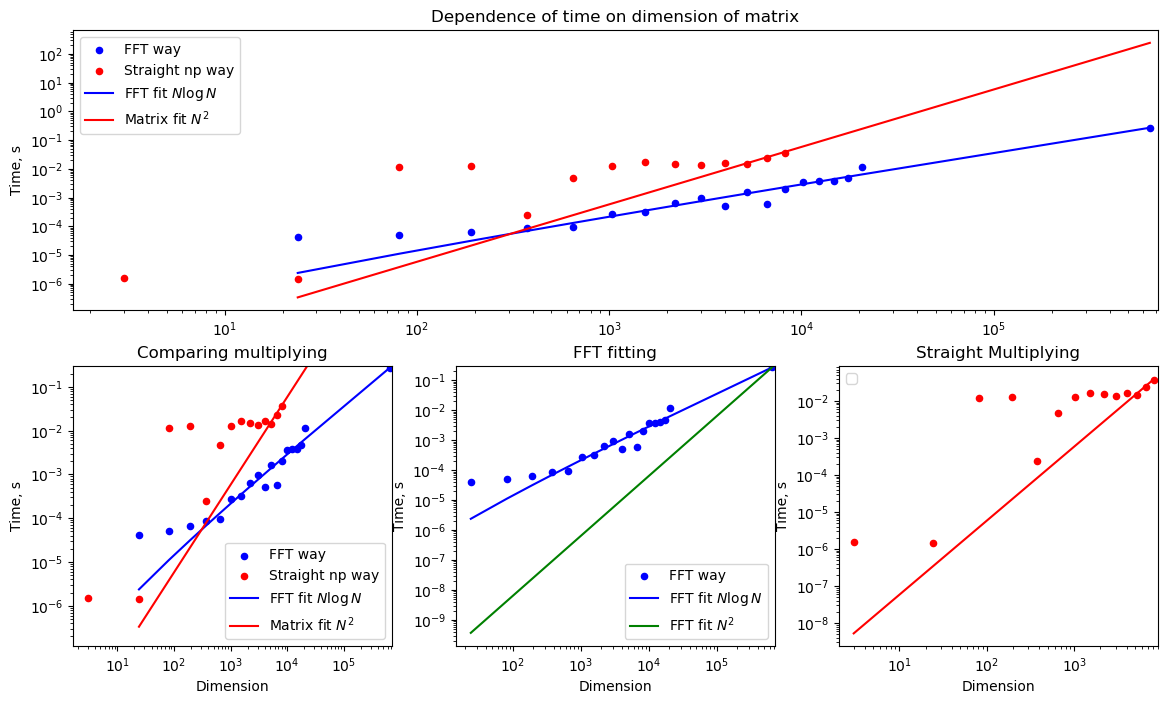

In [163]:
#Analyising time estimation data for anisotropic system
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.optimize import curve_fit

def N3(N, a, b, c):
    return a * N ** 3 + b * N ** 2 + c * N

def N2(N, a, b):
    return abs(a) * N ** 2 

def NlogN(N, a):
    return a * N * np.log(N)


# print(matplotlib.__version__)
# print(matplotlib.get_backend())

# matplotlib.use('nbagg')
# print(matplotlib.get_backend())


# %matplotlib notebook

with open(f"DATA/Time_estimation.json", "r") as res:
    Data = json.loads(res.read())


FFT_time = np.array(Data["FFT Time"])
FFT_time_I = np.array(Data["FFT Time I"])
FFT_time_ZI = np.array(Data["FFT Time ZI"])
FFT_time_V = np.array(Data["FFT Time V"])
Numbers_fft = np.array(Data["Numbers"])

with open(f'DATA/Time_estimation2.json', 'r') as res:
    Data = json.loads(res.read())
Matrix_Time = np.array(Data['Matrix Time'])
Numbers_matrix = np.array(Data['Numbers'])
print(Numbers, Numbers_matrix)


#plt.style.use("classic")
plt.figure(figsize=(14, 8), facecolor="white")

a_fft = curve_fit(NlogN, Numbers_fft, FFT_time)[0][0]
a_fft_n2, b_fft_n2 = curve_fit(N2, Numbers_fft, FFT_time)[0]
a_matrix, b_matrix = curve_fit(N2, Numbers_matrix, Matrix_Time)[0]


# Fit_fft = np.array([NlogN(n, a_fft) for n in Numbers])
# Fit_fft_n2 = np.array([N2(n, a_fft_n2, b_fft_n2) for n in Numbers])
Fit_fft = NlogN(Numbers_fft, a_fft)
Fit_fft_n2 = N2(Numbers_fft, a_fft_n2, b_fft_n2)
Fit_matrix = N2(Numbers_fft, a_matrix, b_matrix)

markersize = 20
plt.subplot(2, 1, 1)

plt.scatter(Numbers_fft, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers_matrix, Matrix_Time, label = 'Straight np way', color = 'red', s = markersize)

plt.plot(Numbers_fft, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.loglog(Numbers_fft, Fit_matrix, label = f'Matrix fit $N^2$', linestyle = '-', color = 'red')

plt.legend()

plt.title("Dependence of time on dimension of matrix")
#plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers_fft)*1.1)


plt.subplot(2, 3, 4)

plt.scatter(Numbers_fft, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers_matrix, Matrix_Time, label = 'Straight np way', color = 'red', s = markersize)

plt.plot(Numbers_fft, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.loglog(Numbers_fft, Fit_matrix, label = f'Matrix fit $N^2$', linestyle = '-', color = 'red')


plt.legend()

plt.title("Comparing multiplying")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers_fft)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 5)

plt.scatter(Numbers_fft, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.plot(Numbers_fft, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.loglog(Numbers_fft, Fit_fft_n2, label = f'FFT fit $N ^2$', linestyle = '-', color = 'green')


plt.legend()

plt.title("FFT fitting")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers_fft)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 6)

plt.legend()

plt.title("Straight Multiplying")
plt.scatter(Numbers_matrix, Matrix_Time, label = 'Straight np way', color = 'red', s = markersize)
Fit_matrix = N2(Numbers_matrix, a_matrix, b_matrix)
plt.loglog(Numbers_matrix, Fit_matrix, label = f'Matrix fir $N^2$', linestyle = '-', color = 'red')
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers_matrix)*1.1)


plt.savefig(f"Plots/Time estimation{type}.png")
plt.show()

In [ ]:
# Time estimation for MRI-Lenzes
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.fft import fftn, ifftn
from functools import reduce
from random import random
from time import time as time
from numpy import sqrt
import json

def multiply(Matrix, Vec):
    res = np.zeros(len(Matrix))
    for i in range(len(res)):
        res[i] = sum([Matrix[i][j] * Vec[j] for j in range(len(Vec))])
    return res

Matrix_time = np.array([], dtype=np.float64)
Solving_time = np.array([], dtype=np.float64)

FFT_time = np.array([], dtype=np.float64)
FFT_time_I = np.array([], dtype=np.float64)
FFT_time_ZI = np.array([], dtype=np.float64)
FFT_time_V = np.array([], dtype=np.float64)

Delta_Matrix = np.array([], dtype=np.float64)
Delta_Solving = np.array([], dtype=np.float64)

Delta_FFT = np.array([], dtype=np.float64)
Delta_FFT_I = np.array([], dtype=np.float64)
Delta_FFT_V = np.array([], dtype=np.float64)
Delta_FFT_ZI = np.array([], dtype=np.float64)

Numbers = np.array([], dtype=np.float64)

DATA = {}
Mu = []
b = 3

Orientations = ('x','y', 'z')

for Nx in range(1, 2):
    for Ny in range(1, 2):
        for Nz in range(1, 15):
            print(Nx, Ny, Nz)
            

            N = {}
            Z_matrixes = {}
            Z_circvecs = {}
            i_vecs = {}
            Rings = {}

            ZI_circ = {}
            ZI_3d = {}
            N["xx"], N["yx"], N["zx"] = Nz + 1, Nz, Nz  # Number of cells on each row for x-oriented rings
            N["xy"], N["yy"], N["zy"] = Nz, Nz + 1, Nz  # Number of cells on each row for y-oriented rings
            N["xz"], N["yz"], N["zz"] = Nz, Nz, Nz + 1  # Number of cells on each row for z-oriented rings
            
            # Describe indexes where rings-vector splits by orietations
            start, end = {}, {}
            start["x"], end["x"] = 0, N['xx'] * N['yx'] * N['zx']
            start["y"], end["y"] = end["x"], end['x'] + N['xy'] * N['yy'] * N['zy']
            start["z"], end["z"] = end["y"], end['y'] + N['xz'] * N['yz'] * N['zz']
           
            for pos in Orientations:
                Rings[pos] = Rectangle_packing(N[f'x{pos}'], N[f'y{pos}'], N[f'z{pos}'], Radius, a, b, c, w, pos)
            Rings_full = np.concatenate([Rings[j] for j in Rings])
            Number = len(Rings_full)

            for pos1 in Orientations:
                for pos2 in Orientations:
                    dim_old = len(Rings[pos1]) * len(Rings[pos2])
                    dim_new = (N[f'z{pos1}'], N[f'z{pos2}'], N[f'y{pos1}'], N[f'y{pos2}'], N[f'x{pos1}'], N[f'x{pos2}'])
                    pair = pos1 + pos2
                    Z_matrixes[pair] = (Matrix(Rings[pos1], Rings[pos2], DATA) * a1/a * mu_0 * omega_0 * 1j).reshape(dim_old).reshape(dim_new)
            print('Blocks:done')


            Z_full = Matrix(Rings_full, Rings_full, DATA) * a1/a * mu_0 * 1j * omega_0
            print('Matrix:Done')


            for pos1 in Orientations:
                for pos2 in Orientations:
                    pair = pos1 + pos2

                    nz = N[f"z{pos1}"] + N[f"z{pos2}"] - 1
                    ny = N[f"y{pos1}"] + N[f"y{pos2}"] - 1
                    nx = N[f"x{pos1}"] + N[f"x{pos2}"] - 1

                    Z_circvecs[pair] = np.zeros((nz, ny, nx), dtype = complex)
                    for z in range(nz):
                        for y in range(ny):
                            for x in range(nx):
                                x_str_id = (nx - x) * (x >= N[f'x{pos2}'])
                                x_col_id = x * (x < N[f'x{pos2}'])

                                y_str_id = (ny - y) * (y >= N[f'y{pos2}'])
                                y_col_id = y * (y < N[f'y{pos2}'])

                                z_str_id = (nz - z) * (z >= N[f'z{pos2}'])
                                z_col_id = z * (z < N[f'z{pos2}'])

                                Z_circvecs[pair][z][y][x] = Z_matrixes[pair][z_str_id][z_col_id][y_str_id][y_col_id][x_str_id][x_col_id]
                    i_vecs[pair] = np.zeros((nz, ny, nx), dtype=complex)
                    ZI_3d[pair] = np.zeros(end[pos1] - start[pos1], dtype=complex)

            print('Circulant:done')

          
            fft_time, fft_time2, fft_time_i, fft_time_i2 = 0,0,0,0
            fft_time_zi, fft_time_zi2, fft_time_v, fft_time_v2 = 0,0,0,0

            I_full = np.linspace(Number // 10, Number * 2, Number)
            ZI_fft = np.zeros(Number)

            for j in range(10):

                Start = np.float64(time())

                Start_i = np.float64(time())

                Z_0 = Z_0

                for pos1 in Orientations:
                    for pos2 in Orientations:
                        pair = pos1 + pos2
                        i_vecs[pair][:N[f'z{pos2}'], :N[f'y{pos2}'], :N[f'x{pos2}']] = I_full[start[pos2]:end[pos2]].reshape((N[f'z{pos2}'], N[f'y{pos2}'], N[f'x{pos2}']))
                        # for j in range(end[pos2] - start[pos2]):
                        #     x = j % N[f'x{pos2}']
                        #     y = (j // N[f'x{pos2}']) % N[f'y{pos2}']
                        #     z = ((j // N[f'x{pos2}']) // N[f'y{pos2}']) % N[f'z{pos2}']
                        #     i_vecs[pair][z][y][x] = I_full[start[pos2] + j]


                End_i = np.float64(time())

                Start_zi = np.float64(time())

                for pos1 in Orientations:
                    for pos2 in Orientations:
                        pair = pos1 + pos2
                        ZI_circ[pair] = fftn(fftn(Z_circvecs[pair]) * ifftn(i_vecs[pair]))

                End_zi = np.float64(time())

                Start_v = np.float64(time())

                for pos1 in Orientations:
                    for pos2 in Orientations:
                        pair = pos1 + pos2
                        ZI_3d[pair] = ZI_circ[pair][:N[f'z{pos1}'], :N[f'y{pos1}'], :N[f'x{pos1}']].reshape(len(Rings[pos1]))
                        # for z in range(N[f"z{pos1}"]):
                        #     for y in range(N[f"y{pos1}"]):
                        #         for x in range(N[f"x{pos1}"]):
                        #             ZI_3d[pair][N[f'y{pos1}'] * N[f'x{pos1}'] * z + N[f'x{pos1}'] * y + x] = \
                        #             ZI_circ[pair][z][y][x]
                    ZI_3d[pos1] = reduce(lambda x, y: x + y, [ZI_3d[f'{pos1}{pos}'] for pos in Orientations])

                for pos in Orientations:
                    ZI_fft[start[pos]:end[pos]] = ZI_3d[pos]

                End_v = np.float64(time())

                End = np.float64(time())

                fft_time += (End - Start) /10
                fft_time2 += (End - Start) ** 2 /10

                fft_time_i += (End_i - Start_i) /10
                fft_time_i2 += (End_i - Start_i) ** 2 /10

                fft_time_zi += (End_zi - Start_zi) /10
                fft_time_zi2 += (End_zi - Start_zi) ** 2 /10

                fft_time_v += (End_v - Start_v) /10
                fft_time_v2 += (End_v - Start_v) ** 2 /10
            
            # Multiplying by straight way

            I_full = np.linspace(Number // 10, Number * 2, Number)

            matrix_time = 0
            matrix_time2 = 0

            for i in range(10):
                Start = np.float64(time())

                ZI_full = Z_full.dot(I_full)

                End = np.float64(time())

                matrix_time += (End - Start) / 10
                matrix_time2 += (End - Start) ** 2 / 10

            Matrix_time = np.append(Matrix_time, matrix_time)
            Delta_Matrix = np.append(Delta_Matrix, sqrt(matrix_time2 - matrix_time ** 2))
            FFT_time = np.append(FFT_time, fft_time)
            Delta_FFT = np.append(Delta_FFT, sqrt(fft_time2 - fft_time ** 2))
            FFT_time_I = np.append(FFT_time_I, fft_time_i)
            Delta_FFT_I = np.append(Delta_FFT_I, sqrt(fft_time_i2 - fft_time_i ** 2))
            FFT_time_ZI = np.append(FFT_time_ZI, fft_time_zi)
            Delta_FFT_ZI = np.append(Delta_FFT_ZI, sqrt(fft_time_zi2 - fft_time_zi ** 2))
            FFT_time_V = np.append(FFT_time_V, fft_time_v)
            Delta_FFT_V = np.append(Delta_FFT_V, sqrt(fft_time_v2 - fft_time_v ** 2))
            Numbers = np.append(Numbers, Number)
            

            Omega = 10 ** 10
            # Need to calculate only with neighours
            SumZ = sum([sum(j) for j in Z_full])/omega_0 * Omega
            C = 1j * Omega * pi ** 2 * Radius1 ** 4 * n_0 * mu_0
            mu = np.real((Z_0 + SumZ + 2/3 * C)/(Z_0 + SumZ - 1/3 * C))
            Mu.append(mu)
            



Time_estimation = {
    "Numbers": list(Numbers),
    "Matrix Time": list(Matrix_time),
    "FFT Time": list(FFT_time),
    "FFT Time I": list(FFT_time_I),
    "FFT Time V": list(FFT_time_V),
    "FFT Time ZI": list(FFT_time_ZI),
    "Delta Matrix": list(Delta_Matrix),
    "Delta FFT": list(Delta_FFT),
    "Delta FFT I": list(Delta_FFT_I),
    "Delta FFT V": list(Delta_FFT_V),
    "Delta FFT ZI": list(Delta_FFT_ZI),
    "Mu": list(Mu)
}

with open("DATA/Time_estimation.json", "w") as res:
    res.write(json.dumps(Time_estimation))


In [7]:
# Time estimation
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
# Fit for time estimation
plt.figure(figsize=(14, 8))

a_i = curve_fit(lambda x, a: a * x, Numbers, FFT_time_I)[0][0]
a_zi = curve_fit(lambda x, a: a * x, Numbers, FFT_time_ZI)[0][0]
a_v = curve_fit(lambda x, a: a * x, Numbers, FFT_time_V)[0][0]

Fit_i = np.array([a_i * n for n in Numbers])
Fit_v = np.array([a_v * n for n in Numbers])
Fit_zi = np.array([a_zi * n for n in Numbers])

Min_fft_i = Fit_i - Delta_FFT_I
Max_fft_i = Fit_i + Delta_FFT_I

Min_fft_zi = Fit_zi - Delta_FFT_ZI
Max_fft_zi = Fit_zi + Delta_FFT_ZI

Min_fft_v = Fit_v - Delta_FFT_V
Max_fft_v = Fit_v + Delta_FFT_V

plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)
plt.fill_between(Numbers, Max_fft_i, Min_fft_i, color = "red", alpha = 0.15)
plt.fill_between(Numbers, Max_fft_zi, Min_fft_zi, color = "black", alpha = 0.15)
plt.fill_between(Numbers, Max_fft_v, Min_fft_v, color = "yellow", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "Total time", color = 'blue', s = 1)
plt.scatter(Numbers, FFT_time_I, label = f'Reshape $I$', color = 'red', s = 1)
plt.scatter(Numbers, FFT_time_ZI, label = f'Multiplying $ZI$', color = 'black', s = 1)
plt.scatter(Numbers, FFT_time_V, label = f'Reshape $V$', color = 'yellow', s = 1)
plt.plot(Numbers, Fit_i, label = f'Average I', linestyle = '-', color = 'red')
plt.plot(Numbers, Fit_zi, label = f'Average ZI', linestyle = '-', color = 'black')
plt.plot(Numbers, Fit_v, label = f'Average V', linestyle = '-', color = 'yellow')
plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
#plt.plot(numbers, Fit_fft_n2, label = f'FFT fit $N^2$', linestyle = '-', color = '#00A86B')

plt.legend()
plt.grid(True)
plt.title("FFT parts")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)

plt.savefig(f"Plots/FFT parts2{type}.png")
plt.show()

NameError: name 'Numbers' is not defined

<Figure size 1400x800 with 0 Axes>

In [ ]:
#Analysing time estimation data for MRI lenz
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.optimize import curve_fit
def N3(N, a, b, c):
    return a * N ** 3 + b * N ** 2 + c * N

def N2(N, a, b):
    return abs(a) * N ** 2 + abs(b) * N

def NlogN(N, a):
    return a * N * np.log(N)


print(matplotlib.__version__)
print(matplotlib.get_backend())

matplotlib.use('nbagg')
print(matplotlib.get_backend())


%matplotlib notebook
type = 2
type = ''
with open(f"DATA/Time_estimation{type}.json", "r") as res:
    Data = json.loads(res.read())

Matrix_time = np.array(Data["Matrix Time"])


FFT_time = np.array(Data["FFT Time"])
FFT_time_I = np.array(Data["FFT Time I"])
FFT_time_ZI = np.array(Data["FFT Time ZI"])
FFT_time_V = np.array(Data["FFT Time V"])

Delta_Matrix = np.array(Data["Delta Matrix"])


Delta_FFT = np.array(Data["Delta FFT"])
Delta_FFT_I = np.array(Data["Delta FFT I"])
Delta_FFT_V = np.array(Data["Delta FFT V"])
Delta_FFT_ZI = np.array(Data["Delta FFT ZI"])

Numbers = np.array(Data["Numbers"])
Mu = np.array(Data['Mu'])


for i in range(len(Numbers)):
    for j in range(len(Numbers) - 1):
        if Numbers[j] > Numbers[j + 1]:
            Numbers[j], Numbers[j+1] = Numbers[j+1], Numbers[j]

            Matrix_time[j], Matrix_time[j+1] = Matrix_time[j+1], Matrix_time[j]

            FFT_time[j], FFT_time[j+1] =  FFT_time[j+1],  FFT_time[j]
            FFT_time_I[j], FFT_time_I[j+1] =  FFT_time_I[j+1],  FFT_time_I[j]
            FFT_time_ZI[j], FFT_time_ZI[j+1] =  FFT_time_ZI[j+1],  FFT_time_ZI[j]
            FFT_time_V[j], FFT_time_V[j+1] =  FFT_time_V[j+1],  FFT_time_V[j]

            Delta_Matrix[j], Delta_Matrix[j+1] = Delta_Matrix[j+1], Delta_Matrix[j]

            Delta_FFT[j], Delta_FFT[j+1] =  Delta_FFT[j+1],  Delta_FFT[j]
            Delta_FFT_I[j], Delta_FFT_I[j+1] =  Delta_FFT_I[j+1],  Delta_FFT_I[j]
            Delta_FFT_ZI[j], Delta_FFT_ZI[j+1] =  Delta_FFT_ZI[j+1],  Delta_FFT_ZI[j]
            Delta_FFT_V[j], Delta_FFT_V[j+1] =  Delta_FFT_V[j+1],  Delta_FFT_V[j]
            Mu[j], Mu[j+1] = Mu[j+1], Mu[j]

smooth_lenght = 20
for i in range(len(Numbers)//smooth_lenght + 1):
    Start = smooth_lenght * i
    End = min(len(Numbers), smooth_lenght * (i + 1))
    l = End - Start
    #Matrix_time[Start:End] = np.ones(l) * sum(Matrix_time[Start:End])/l
    #Solving_time[Start:End] = np.ones(l) * sum(Solving_time[Start:End])/l

    #FFT_time[Start:End] = np.ones(l) * sum(FFT_time[Start:End])/l
    #FFT_time_I[Start:End] = np.ones(l) * sum(FFT_time_I[Start:End])/l
    #FFT_time_ZI[Start:End] = np.ones(l) * sum(FFT_time_ZI[Start:End])/l
    #FFT_time_V[Start:End] = np.ones(l) * sum(FFT_time_V[Start:End])/l


    Delta_Matrix[Start:End] = np.ones(l) * sum(Delta_Matrix[Start:End])/l

    Delta_FFT[Start:End] = np.ones(l) * sum(Delta_FFT[Start:End])/l
    Delta_FFT_I[Start:End] = np.ones(l) * sum(Delta_FFT_I[Start:End])/l
    Delta_FFT_ZI[Start:End] = np.ones(l) * sum(Delta_FFT_ZI[Start:End])/l
    Delta_FFT_V[Start:End] = np.ones(l) * sum(Delta_FFT_V[Start:End])/l


#plt.style.use("classic")
plt.figure(figsize=(14, 8), facecolor="white")

a_fft = curve_fit(NlogN, Numbers, FFT_time)[0][0]
a_fft_n2, b_fft_n2 = curve_fit(N2, Numbers, FFT_time)[0]
a_matrix, b_matrix = curve_fit(N2, Numbers, Matrix_time)[0]
a_matrix_n3, b_matrix_n3, c_matrix_n3 = curve_fit(N3, Numbers, Matrix_time)[0]

a_fft_min = curve_fit(NlogN, Numbers, FFT_time - Delta_FFT)[0][0]
a_matrix_min, b_matrix_min = curve_fit(N2, Numbers, Matrix_time - Delta_Matrix)[0]

a_fft_max = curve_fit(NlogN, Numbers, FFT_time + Delta_FFT)[0][0]
a_matrix_max, b_matrix_max = curve_fit(N2, Numbers, Matrix_time + Delta_Matrix)[0]

Fit_fft = np.array([NlogN(n, a_fft) for n in Numbers])
Fit_fft_n2 = np.array([N2(n, a_fft_n2, b_fft_n2) for n in Numbers])
Fit_matrix = np.array([N2(n, a_matrix, b_matrix) for n in Numbers])
Fit_matrix_n3 = np.array([N3(n, a_matrix_n3, b_matrix_n3, c_matrix_n3) for n in Numbers])


Min_fft = [max(Fit_fft[j] - Delta_FFT[j],  0) for j in range(len(Fit_fft))]
Max_fft = Fit_fft + Delta_FFT

Min_matrix = [max(Fit_matrix[j] - Delta_Matrix[j], 0)for j in range(len(Fit_matrix))]
Max_matrix = Fit_matrix + Delta_Matrix

markersize = 20
plt.subplot(2, 1, 1)


plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)
#plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)

plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.plot(Numbers, Fit_matrix, label = f'Fit Straight $N^2$', linestyle = '-', color = 'red')

plt.legend()
plt.grid(True)
plt.title("Dependence of time on dimension of matrix")
#plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)


plt.subplot(2, 3, 4)

plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)
#plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)
plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.plot(Numbers, Fit_matrix, label = f'Fit straight $N^2$', linestyle = '-', color = 'red')

plt.legend()
plt.grid(True)
plt.title("Comparing multiplying")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 5)

plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
#plt.plot(numbers, Fit_fft_n2, label = f'FFT fit $N^2$', linestyle = '-', color = 'red')

plt.legend()
plt.grid(True)
plt.title("FFT fitting")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 6)

#plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)
plt.plot(Numbers, Fit_matrix, label = f'Fit straight $N^2$', linestyle = '-', color = 'red')
#plt.plot(numbers, Fit_matrix_n3, label =f'Fit straight $N^3$', linestyle = '-', color = "yellow")

plt.legend()
plt.grid(True)
plt.title("Straight Multiplying")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-Matrix_time[-1]/10, Matrix_time[-1] * 1.1)

plt.savefig(f"Plots/Time estimation{type}.png")
plt.show()

In [ ]:
#Analyising time estimation data for anisotropic system
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.optimize import curve_fit

def N3(N, a, b, c):
    return a * N ** 3 + b * N ** 2 + c * N

def N2(N, a, b):
    return abs(a) * N ** 2 + abs(b) * N

def NlogN(N, a):
    return a * N * np.log(N)


# print(matplotlib.__version__)
# print(matplotlib.get_backend())

# matplotlib.use('nbagg')
# print(matplotlib.get_backend())


# %matplotlib notebook
#type = 2
type = ''
with open(f"DATA/Time_estimation{type}.json", "r") as res:
    Data = json.loads(res.read())

Matrix_time = np.array(Data["Matrix Time"])


FFT_time = np.array(Data["FFT Time"])
FFT_time_I = np.array(Data["FFT Time I"])
FFT_time_ZI = np.array(Data["FFT Time ZI"])
FFT_time_V = np.array(Data["FFT Time V"])

Delta_Matrix = np.array(Data["Delta Matrix"])


Delta_FFT = np.array(Data["Delta FFT"])
Delta_FFT_I = np.array(Data["Delta FFT I"])
Delta_FFT_V = np.array(Data["Delta FFT V"])
Delta_FFT_ZI = np.array(Data["Delta FFT ZI"])

Numbers = np.array(Data["Numbers"])
Mu = np.array(Data['Mu'])

#plt.style.use("classic")
plt.figure(figsize=(14, 8), facecolor="white")

a_fft = curve_fit(NlogN, Numbers, FFT_time)[0][0]
a_fft_n2, b_fft_n2 = curve_fit(N2, Numbers, FFT_time)[0]
a_matrix, b_matrix = curve_fit(N2, Numbers, Matrix_time)[0]
a_matrix_n3, b_matrix_n3, c_matrix_n3 = curve_fit(N3, Numbers, Matrix_time)[0]

a_fft_min = curve_fit(NlogN, Numbers, FFT_time - Delta_FFT)[0][0]
a_matrix_min, b_matrix_min = curve_fit(N2, Numbers, Matrix_time - Delta_Matrix)[0]

a_fft_max = curve_fit(NlogN, Numbers, FFT_time + Delta_FFT)[0][0]
a_matrix_max, b_matrix_max = curve_fit(N2, Numbers, Matrix_time + Delta_Matrix)[0]

Fit_fft = np.array([NlogN(n, a_fft) for n in Numbers])
Fit_fft_n2 = np.array([N2(n, a_fft_n2, b_fft_n2) for n in Numbers])
Fit_matrix = np.array([N2(n, a_matrix, b_matrix) for n in Numbers])
#Matrix_time = np.array(list(Matrix_time[:5]) + [N2(n, a_matrix, b_matrix) for n in Numbers[5:]])
Fit_matrix_n3 = np.array([N3(n, a_matrix_n3, b_matrix_n3, c_matrix_n3) for n in Numbers])


Min_fft = [max(Fit_fft[j] - Delta_FFT[j],  0) for j in range(len(Fit_fft))]
Max_fft = Fit_fft + Delta_FFT

Min_matrix = [max(Fit_matrix[j] - Delta_Matrix[j], 0)for j in range(len(Fit_matrix))]
Max_matrix = Fit_matrix + Delta_Matrix

markersize = 20
plt.subplot(2, 1, 1)


plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)
plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)

plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.plot(Numbers, Fit_matrix, label = f'Fit Straight $N^2$', linestyle = '-', color = 'red')

plt.legend()
plt.grid(True)
plt.title("Dependence of time on dimension of matrix")
#plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)


plt.subplot(2, 3, 4)

plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)
plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)
plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')
plt.plot(Numbers, Fit_matrix, label = f'Fit straight $N^2$', linestyle = '-', color = 'red')

plt.legend()
plt.grid(True)
plt.title("Comparing multiplying")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 5)

plt.fill_between(Numbers, Max_fft, Min_fft, color = "blue", alpha = 0.15)

plt.scatter(Numbers, FFT_time, label = "FFT way", color = 'blue', s = markersize)
plt.plot(Numbers, Fit_fft, label = f'FFT fit $N \log N$', linestyle = '-', color = 'blue')

plt.legend()
plt.grid(True)
plt.title("FFT fitting")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-FFT_time[-1]/10, FFT_time[-1] * 1.1)


plt.subplot(2, 3, 6)

plt.fill_between(Numbers, Max_matrix, Min_matrix, color = "red", alpha = 0.15)

plt.scatter(Numbers, Matrix_time, label = "Straight way", color = 'red', s = markersize)
plt.plot(Numbers, Fit_matrix, label = f'Fit straight $N^2$', linestyle = '-', color = 'red')


plt.legend()
plt.grid(True)
plt.title("Straight Multiplying")
plt.xlabel('Dimension')
plt.ylabel('Time, s')
plt.xlim(0, max(Numbers)*1.1)
plt.ylim(-Matrix_time[-1]/10, Matrix_time[-1] * 1.1)

plt.savefig(f"Plots/Time estimation{type}.png")
plt.show()

# About solving system and other notes

Result is solution of matrix equation:

$j\omega M  + diag(Z_0) = E = \dfrac{\text{d}\Phi}{\text{d}t} = j \cdot \omega \cdot \mu_0H_{0z} \pi r^2$

$\chi  = \dfrac{M}{H_{0z}} = \dfrac{P}{V \cdot H_{0z}} = \dfrac{\pi r^2 \sum\limits_{N} I}{N \cdot abc \cdot H_{0z}} = \langle I\rangle \cdot \dfrac{\pi r^2}{abcH_{0z}}$

$\omega \in 40-80 MHz$,  $H_{0z} = 10^{-9}$, $r \approx  0.5 \cdot 10^{-2}$, $a = b = c = 1.5 \cdot 10 ^{-2}$

$\chi \approx \langle I \rangle \cdot 2.27 \cdot 10^{10}$, $Re\left(\dfrac{E_0}{Z_0}\right) \approx 10^{-4}$

In [143]:
#Checking fft method for multiplying

import pyfftw
from scipy.fft import fftn, ifftn
#ZI_circ = fftn(fftn(Z_circvecs) * ifftn(i_vecs))

A = np.array([[1, 2, 3], [3, 1, 2], [2, 3, 1]], dtype=np.complex128)
Circ = np.array([1, 2, 3], dtype = np.complex128)
Circ2 = np.array([1, 3, 2], dtype = np.complex128)
I  = np.array([1, 7, 0], dtype=np.complex128)
B = A.dot(I)
print(B)
ifft_I = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_Circ = pyfftw.empty_aligned(3, dtype = 'complex128')
fft_B = pyfftw.empty_aligned(3, dtype = 'complex128')
pyfftw.FFTW(I, ifft_I).execute()
pyfftw.FFTW(Circ2, fft_Circ).execute()
pyfftw.FFTW(fft_Circ * ifft_I, fft_B, direction = 'FFTW_BACKWARD').execute()
print(fft_B/3)
print(ifftn(fftn(I) * fftn(Circ2)))






[15.+0.j 10.+0.j 23.+0.j]
[15.+0.j 10.+0.j 23.+0.j]
[15.+0.j 10.+0.j 23.+0.j]


0.9804351481677754
-1.1134669517082396


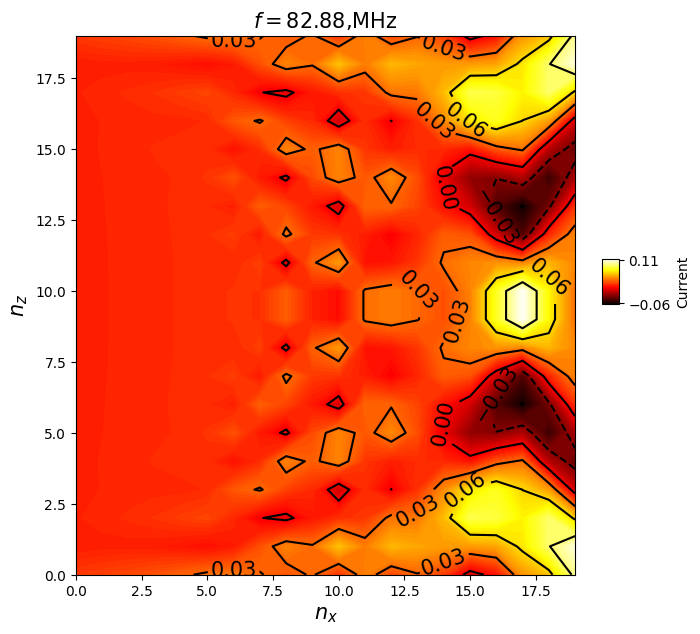

In [124]:
MaxMiddleXZCurrents = np.real(Currents3D[:, :, N['y']//2, :]).max()
MinMiddleXZCurrents = np.real(Currents3D[:, :, N['y']//2, :]).min()
MaxMiddleYZCurrents = np.real(Currents3D[:, :, :, N['x']//2]).max()
MinMiddleYZCurrents = np.real(Currents3D[:, :, :, N['x']//2]).min()
MaxMiddleXYCurrents = np.real(Currents3D[:, N['z']//2, :, :]).max()
MinMiddleXYCurrents = np.real(Currents3D[:, N['z']//2, :, :]).min()
print(MaxMiddleXZCurrents)
print(MinMiddleXZCurrents)
for I0, omega in zip([Currents[368]], [Omega[409]]):
            I = I0.reshape((N['z'], N['y'], N['x']))
            X = list(range(N['x']))
            Y = list(range(N['y']))
            Z = list(range(N['z']))
            fig, ax = plt.subplots()
            fig.set_size_inches((7, 7))
            CurrentsXZ = np.array([[np.real(I[z][N['y']//2][x]) for x in X] for z in Z])
            LinesXZ = plt.contour(X, Z, CurrentsXZ, 6, colors = 'black')
            Imax, Imin = CurrentsXZ.max(), CurrentsXZ.min()
            DeltaCurrents = np.real(Imax) - np.real(Imin)
            MaxDeltaCurrents = MaxMiddleXZCurrents - MinMiddleXZCurrents
            amplitude = DeltaCurrents/MaxDeltaCurrents
            middlepos = (Imin-MinMiddleXZCurrents)/(MaxDeltaCurrents - DeltaCurrents)
            ticksnumber = round(amplitude * 10) + 1
            ticks = list(map(lambda x: round(x, 2), np.linspace(Imax, Imin, ticksnumber)))

            plt.xlabel(r'$n_x$', fontsize = 15)
            plt.ylabel(r'$n_z$', fontsize = 15)
            plt.title(f"$f =${round(omega/2/pi/10 ** 6, 2)},MHz", fontsize = 15)

            plt.contourf(X, Z, CurrentsXZ, 100, cmap=plt.cm.hot)
            plt.clabel(LinesXZ, inline=1, fontsize=15)
            plt.colorbar(label = 'Current', fraction = 0.03, pad = 0.05, 
                         shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
                         ticks = ticks
                         )

            #plt.savefig(f'/Users/shuramakarenko/Discrete_Model_Of_Metamaterial_Lens/Code/Plots/{type}-grad = {max(grad)}/ZX-f={round(omega/2/pi/10 ** 6, 2)}MHz.png')

In [ ]:
# Checking parameters
print(f"Radius: {Radius1}")
print(f"Volume per ring: {a1 * b1 * c1}")
print(f'Area of ring:{pi * Radius1 ** 2}')
print(f'H: {10 ** -9}')
Const = pi * Radius1 ** 2 /a1/b1/c1/H_0z/10 ** 10
omega = 2 * pi * 65 * 10 ** 6
print(f'Omega: {omega/2/pi/10 ** 6}MHz')
Z_0 = R  + 1j * omega * L + 1/(1j * omega * C)
print(f'Z_0: {Z_0}')
E_0 = H_0z * pi * Radius1 ** 2 * 1j * omega
print(f'E_0: {E_0}')
print(f'E_0/Z_0: {E_0/Z_0}')

Omega = np.linspace( 2 * pi * 60 * 10 ** 6, 2 * pi * 66 * 10 ** 6, 1000)
Z_0 = [E_0/(R + 1j * omega * L + 1/ (1j * omega * C)) for omega in Omega]
plt.figure()
plt.xlabel('X')
plt.ylabel('Y')
X = list(range(1, 11))
Y = list(range(1, 22))
Z = [[y + x for x in X] for y in Y]
Z = [[Z[y-1][x-1] for x in X] for y in Y]
plt.contourf(X, Y, Z, 100)
plt.colorbar()